In [1]:
from huggingface_hub import notebook_login

notebook_login()

In [2]:
model_ckpt = "MCG-NJU/videomae-base" # pre-trained model from which to fine-tune
batch_size = 4 # batch size for training and evaluation

In [3]:
!pip install pytorchvideo transformers evaluate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 29.7 MB/s eta 0:00:00


In [3]:
!git config --global credential.helper store

In [4]:
from huggingface_hub import hf_hub_download


hf_dataset_identifier = "sayakpaul/ucf101-subset"
filename = "UCF101_subset.tar.gz"
file_path = hf_hub_download(
    repo_id=hf_dataset_identifier, filename=filename, repo_type="dataset"
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
!tar xf {file_path}

In [6]:
dataset_root_path = "UCF101_subset"

!find {dataset_root_path} | head -5

UCF101_subset
UCF101_subset/train
UCF101_subset/train/BalanceBeam
UCF101_subset/train/BalanceBeam/v_BalanceBeam_g12_c04.avi
UCF101_subset/train/BalanceBeam/v_BalanceBeam_g06_c01.avi


In [7]:
import pathlib

dataset_root_path = pathlib.Path(dataset_root_path)

In [8]:
video_count_train = len(list(dataset_root_path.glob("train/*/*.avi")))
video_count_val = len(list(dataset_root_path.glob("val/*/*.avi")))
video_count_test = len(list(dataset_root_path.glob("test/*/*.avi")))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 405


In [9]:
all_video_file_paths = (
    list(dataset_root_path.glob("train/*/*.avi"))
    + list(dataset_root_path.glob("val/*/*.avi"))
    + list(dataset_root_path.glob("test/*/*.avi"))
)
all_video_file_paths[:5]

[PosixPath('UCF101_subset/train/BalanceBeam/v_BalanceBeam_g12_c04.avi'),
 PosixPath('UCF101_subset/train/BalanceBeam/v_BalanceBeam_g06_c01.avi'),
 PosixPath('UCF101_subset/train/BalanceBeam/v_BalanceBeam_g01_c03.avi'),
 PosixPath('UCF101_subset/train/BalanceBeam/v_BalanceBeam_g25_c01.avi'),
 PosixPath('UCF101_subset/train/BalanceBeam/v_BalanceBeam_g07_c02.avi')]

In [10]:
class_labels = sorted({str(path).split("/")[2] for path in all_video_file_paths})
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")

Unique classes: ['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam', 'BandMarching', 'BaseballPitch', 'Basketball', 'BasketballDunk', 'BenchPress'].


In [11]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification


image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

In [13]:
import os

mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
sample_rate = 4
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps


# Training dataset transformations.
train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    RandomCrop(resize_to),
                    RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)

# Training dataset.
train_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "train"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

# Validation and evaluation datasets' transformations.
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)

# Validation and evaluation datasets.
val_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "val"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

test_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "test"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

In [14]:
# We can access the `num_videos` argument to know the number of videos we have in the
# dataset.
train_dataset.num_videos, val_dataset.num_videos, test_dataset.num_videos

(300, 30, 75)

In [15]:
sample_video = next(iter(train_dataset))
sample_video.keys()

dict_keys(['video', 'video_name', 'video_index', 'clip_index', 'aug_index', 'label'])

In [16]:
def investigate_video(sample_video):
    """Utility to investigate the keys present in a single video sample."""
    for k in sample_video:
        if k == "video":
            print(k, sample_video["video"].shape)
        else:
            print(k, sample_video[k])

    print(f"Video label: {id2label[sample_video[k]]}")


investigate_video(sample_video)

video torch.Size([3, 16, 224, 224])
video_name v_Basketball_g01_c01.avi
video_index 210
clip_index 0
aug_index 0
label 7
Video label: Basketball


In [17]:
import imageio
import numpy as np
from IPython.display import Image


def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)


def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.

    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename


def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

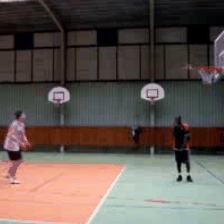

In [18]:
video_tensor = sample_video["video"]
display_gif(video_tensor)

In [21]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 4.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [22]:
!pip install transformers[torch]

In [19]:
from transformers import TrainingArguments, Trainer

model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-finetuned-ucf101-subset"
num_epochs = 50

args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
)

In [ ]:
# train_dataset.num_videos
# batch_size

4

In [20]:
import evaluate

metric = evaluate.load("accuracy")

In [21]:
# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions."""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [22]:
import torch


def collate_fn(examples):
    """The collation function to be used by `Trainer` to prepare data batches."""
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [23]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

max_steps is given, it will override any value given in num_train_epochs


In [24]:
train_results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
0,2.317400,2.312683,0.142857
1,2.029300,1.786833,0.442857
2,0.853300,0.853605,0.700000
3,1.067800,0.771807,0.757143
4,0.485300,0.847871,0.700000
5,0.365500,0.217931,0.914286
6,0.184200,0.214317,0.957143
7,0.019300,0.965183,0.757143
8,0.148800,0.360681,0.900000
9,0.006100,0.355820,0.928571


In [25]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.23898714780807495,
 'eval_accuracy': 0.9419354838709677,
 'eval_runtime': 48.1327,
 'eval_samples_per_second': 3.22,
 'eval_steps_per_second': 0.81,
 'epoch': 49.02}

In [26]:
trainer.save_model()
test_results = trainer.evaluate(test_dataset)
trainer.log_metrics("test", test_results)
trainer.save_metrics("test", test_results)
trainer.save_state()

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

events.out.tfevents.1715085791.3fdb0502d8b0.1713.1:   0%|          | 0.00/411 [00:00<?, ?B/s]

events.out.tfevents.1715075258.3fdb0502d8b0.1713.0:   0%|          | 0.00/101k [00:00<?, ?B/s]

***** test metrics *****
  epoch                   =      49.02
  eval_accuracy           =     0.9419
  eval_loss               =      0.239
  eval_runtime            = 0:00:48.26
  eval_samples_per_second =      3.211
  eval_steps_per_second   =      0.808


In [27]:
trainer.push_to_hub()

events.out.tfevents.1715085791.3fdb0502d8b0.1713.1:   0%|          | 0.00/734 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/GoblinCyanide/videomae-base-finetuned-ucf101-subset/commit/983811c3110354cc29cff2c30f42076f4f4d84b8', commit_message='End of training', commit_description='', oid='983811c3110354cc29cff2c30f42076f4f4d84b8', pr_url=None, pr_revision=None, pr_num=None)

In [28]:
trained_model = VideoMAEForVideoClassification.from_pretrained(new_model_name)

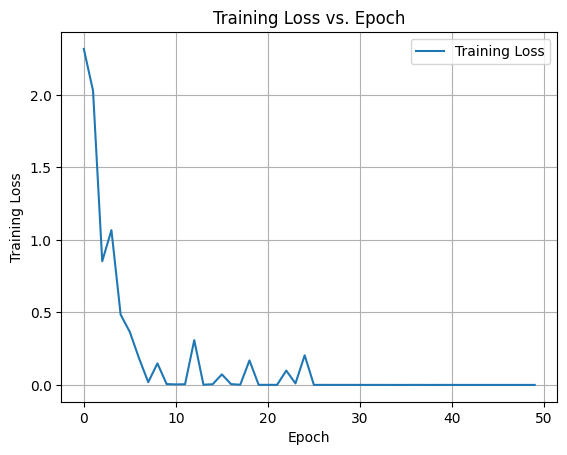

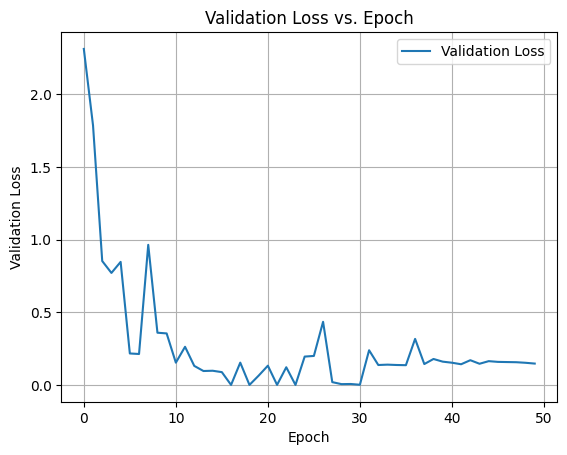

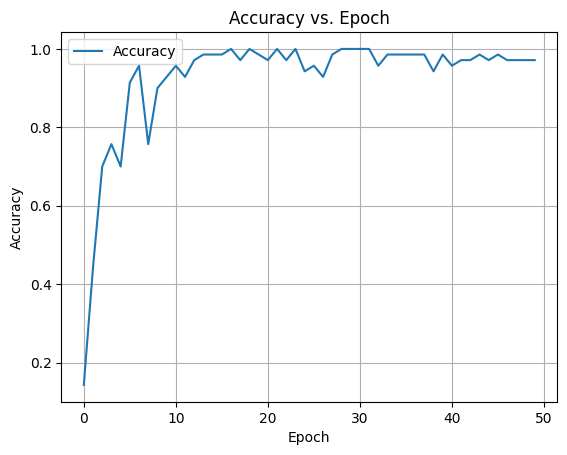

In [3]:
import matplotlib.pyplot as plt

# Provided data
epochs = list(range(50))

training_loss = [
    2.317400, 2.029300, 0.853300, 1.067800, 0.485300, 0.365500, 0.184200, 0.019300, 0.148800, 0.006100,
    0.004000, 0.005000, 0.309300, 0.001800, 0.005100, 0.073100, 0.005800, 0.001800, 0.169400, 0.001000,
    0.000900, 0.000800, 0.099200, 0.010800, 0.204700, 0.000700, 0.000700, 0.000600, 0.000600, 0.000600,
    0.000500, 0.000500, 0.000500, 0.000500, 0.000400, 0.000400, 0.000600, 0.000400, 0.000400, 0.000500,
    0.000400, 0.000400, 0.000400, 0.000400, 0.000400, 0.000400, 0.000400, 0.000400, 0.000400, 0.000400
]

validation_loss = [
    2.312683, 1.786833, 0.853605, 0.771807, 0.847871, 0.217931, 0.214317, 0.965183, 0.360681, 0.355820,
    0.154675, 0.263832, 0.132459, 0.097235, 0.099100, 0.089497, 0.001582, 0.154889, 0.001553, 0.065555,
    0.133894, 0.001920, 0.123095, 0.001610, 0.196485, 0.200892, 0.435730, 0.020803, 0.007020, 0.007961,
    0.002760, 0.240054, 0.138528, 0.141033, 0.138613, 0.137332, 0.318122, 0.145141, 0.179960, 0.161636,
    0.154311, 0.143776, 0.171561, 0.147133, 0.165054, 0.160013, 0.158805, 0.157711, 0.153817, 0.148383
]

accuracy = [
    0.142857, 0.442857, 0.700000, 0.757143, 0.700000, 0.914286, 0.957143, 0.757143, 0.900000, 0.928571,
    0.957143, 0.928571, 0.971429, 0.985714, 0.985714, 0.985714, 1.000000, 0.971429, 1.000000, 0.985714,
    0.971429, 1.000000, 0.971429, 1.000000, 0.942857, 0.957143, 0.928571, 0.985714, 1.000000, 1.000000,
    1.000000, 1.000000, 0.957143, 0.985714, 0.985714, 0.985714, 0.985714, 0.985714, 0.942857, 0.985714,
    0.957143, 0.971429, 0.971429, 0.985714, 0.971429, 0.985714, 0.971429, 0.971429, 0.971429, 0.971429
]

# Plotting training loss vs. epoch
# plt.plot(epochs, training_loss, label='Training Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Training Loss')
# plt.title('Training Loss vs. Epoch')
# plt.legend()
# plt.grid(True)
# plt.show()

# Plotting validation loss vs. epoch
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, accuracy, label='Accuracy')
plt.xlabel('Epoch')
# plt.ylabel('Validation Loss')
# plt.title('Validation Loss vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Plotting accuracy vs. epoch
# plt.plot(epochs, accuracy, label='Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Accuracy vs. Epoch')
# plt.legend()
# plt.grid(True)
# plt.show()


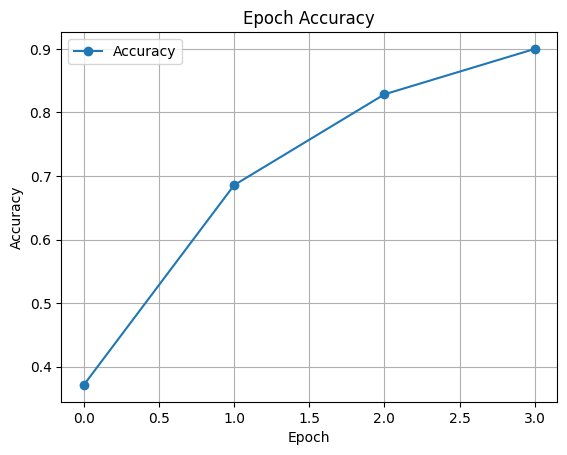

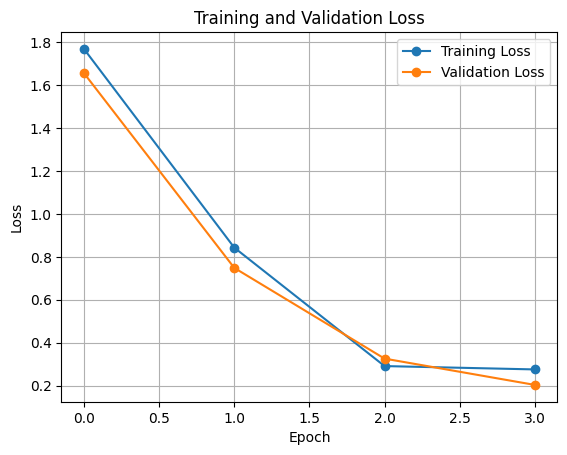

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample data
epochs = [0, 1, 2, 3]
training_loss = [1.767700, 0.842900, 0.291400, 0.275800]
validation_loss = [1.654982, 0.748549, 0.326110, 0.203674]
accuracy = [0.371429, 0.685714, 0.828571, 0.900000]

# Plotting epoch accuracy graph
plt.plot(epochs, accuracy, label='Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Creating a DataFrame for further analysis
data = {'Epoch': epochs, 'Training Loss': training_loss, 'Validation Loss': validation_loss, 'Accuracy': accuracy}
df = pd.DataFrame(data)

# Plotting training and validation loss
plt.plot(df['Epoch'], df['Training Loss'], label='Training Loss', marker='o')
plt.plot(df['Epoch'], df['Validation Loss'], label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [29]:
sample_test_video = next(iter(test_dataset))
investigate_video(sample_test_video)

video torch.Size([3, 16, 224, 224])
video_name v_BasketballDunk_g12_c05.avi
video_index 62
clip_index 0
aug_index 0
label 8
Video label: BasketballDunk


In [30]:
def run_inference(model, video):
    """Utility to run inference given a model and test video.

    The video is assumed to be preprocessed already.
    """
    # (num_frames, num_channels, height, width)
    perumuted_sample_test_video = video.permute(1, 0, 2, 3)

    inputs = {
        "pixel_values": perumuted_sample_test_video.unsqueeze(0),
        "labels": torch.tensor(
            [sample_test_video["label"]]
        ),  # this can be skipped if you don't have labels available.
    }
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model = model.to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    return logits

In [31]:
logits = run_inference(trained_model, sample_test_video["video"])

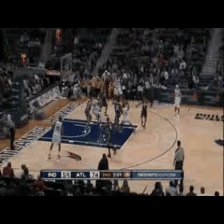

In [32]:
display_gif(sample_test_video["video"])

In [33]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: BasketballDunk


NameError: name 'plt' is not defined

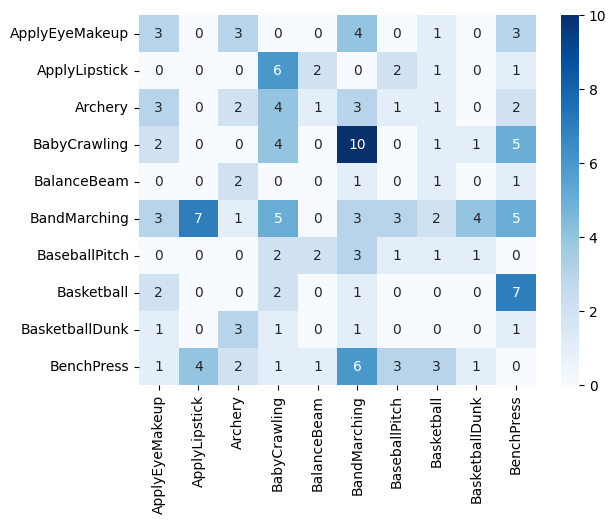

In [34]:
# prompt: make confusion matrix for this model

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the true and predicted labels
true_labels = [sample["label"] for sample in test_dataset]
predicted_labels = []
for sample in test_dataset:
    logits = run_inference(trained_model, sample["video"])
    predicted_labels.append(logits.argmax(-1).item())

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
